# Le modèle de ségrégation de Schelling
L. Rannou (basé sur S. Stinckwich)  
*ARE DYNAMIC - 2020*

## Préambule

En Décembre 2016 disparaissait Thomas C. Schelling. Economiste, récipiendaire du Prix de la Banque de Suède en sciences économiques (communément appelé et considéré comme le prix Nobel d’économie), il a travaillé sur de nombreux sujets, en particulier l’analyse des conflits.

Une de ses contributions a permis de mieux comprendre les phénomènes de ségrégation. Plus précisément, le propos de Schelling fut d’étudier la dynamique par laquelle **des phénomènes de ségrégation extrêmes** peuvent survenir, en dépit de **préférences qui peuvent sembler faiblement discriminantes individuellement**. Ainsi, même si chaque individu se déclare prêt à accepter une certaine proportion d’invidus « différents » dans son voisinage, le résultat final peut être que la population se regroupe en régions très homogènes.

Cette étude peut être menée à l’aide de modèles connus sous le nom d’automates cellulaires. Un des automates les plus célèbres est le [jeu de la vie](https://fr.wikipedia.org/wiki/Jeu_de_la_vie), proposé par John Conway en 1970. Il existe de nombreux autres automates cellulaires dont le comportement est relativement bien étudié, et la littérature est riche à ce sujet. Nous recommandons la lecture de l’article [2] de Jean-Paul Delahaye.

## Objectifs

Dans ce notebook nous allons essayer de modéliser la répartition d'une population humaine sur une aire urbaine (un *monde*). Nous allons essayer de comprendre les différentes formes de ségration et de communautarisme pouvant avoir lieu dans les villes.
Nous partons d'une hypothèse primordiale : **chaque individu est indépendant cependant il ne peut pas se sentir confortable dans un quartier où les habitants sont en majorité "différents" de lui.**

Dans un premier temps nous allons modéliser cette répartition une aire urbaine simple : une rue ou une avenue (modèle linéaire).
Puis dans un second temps nous modéliserons cette répartition à l'échelle d'une ville (modèle spatial).


# 1ère partie : Modèle linéaire

Considérons un monde *linéaire* (c’est en fait le premier modèle étudié par Schelling dans son article [1], à quelques détails près). Le modèle se compose des éléments suivants.

- Les *individus* sont de deux *types* (« 0 » et « 1 »), disposés spatialement sur une ligne de taille $n$ (le *monde*).
- Le *voisinage* d'un *individu* est constitué de ses 8 voisins de part et d'autre de sa cellule (4 à sa gauche et 4 à sa droite). Il faut noter que le nombre de voisins peut varier selon la localisation (pour les individus en bout de ligne).
- Le *seuil de satisfaction* : un *individu* est satisfait si une majorité (faible) de ses voisins est du même *type* que lui (i.e. il veut **au moins** autant de voisins du même *type* que lui que de voisins d'un *type* différent).
- Le *mode de déplacement* : un *individu* non satisfait va chercher à se déplacer pour trouver un emplacement qui le satisfasse (un emplacement dont le *voisinage* respecte son *seuil de satisfaction*). Dans le cas où plusieurs emplacements peuvent le satisfaire, un *individu* se déplace vers l’emplacement le plus proche. Si deux emplacements à la même distance sont satisfaisants l'emplacement de droite est privilégié.
- La *dynamique des déplacements* : tous les individus sont considérés, de gauche à droite. Chaque individu non satisfait **s'insère** à l’emplacement satisfaisant le plus proche. Un *tour* est terminé lorsque tous les agents ont été considérés.


À l'issu d'un *tour* des individus peuvent se retrouver à nouveau insatisfaits, dû aux déplacements de leurs voisins.
Partant d’un état initial, le processus est répété jusqu’à équilibre, c’est-à-dire jusqu’à ce que plus aucun individu insatisfait ne puisse se déplacer, ou qu’une situation de blocage soit détectée. Cela peut nécessiter plusieurs *tours*.

### Example

Pour illustrer le propos, considérons la situation initiale suivante :

![Linear Model 1](linearmodel1.png)

Les individus non satisfaits sont indiqués en gris dans la table. Le premier individu à se déplacer sera donc le deuxième en partant de la gauche. En effet, son voisinage ne comprend qu’un autre individu de type "1" (et 4 de type "0"). Pour trouver une place satisfaisante, il va devoir se déplacer de 6 cases vers la droite (l'emplacement satisfaisant le plus proche).

Le nouvel état du monde sera alors (l’individu s’étant déplacé est en gras):

![Linear Model 2](linearmodel2.png)


### Références
- [1] Thomas C. Schelling, [Dynamic Models of Segregation](http://www.stat.berkeley.edu/~aldous/157/Papers/Schelling_Seg_Models.pdf), Journal of Mathematical Sociology (1971) 143-186
- [2] J.-P. Delahaye, [Le royaume du jeu de la vie](http://www.lifl.fr/~jdelahay/dnalor/Jeudelavie.pdf), Pour la Science (2009) 378

#  Etude du modèle "linéaire"

**Objectifs : implémenter le modèle de Schelling en python, le tester sur un exemple simple puis étudier l'impact que peuvent avoir les paramètres du modèle sur le monde.**

Nous allons étudier l’impact des paramètres du modèle : 
- la taille du voisinage,
- le seuil de satisfaction des individus,
- la configuration initiale,
- les règles de mouvement (le mode de déplacement).

Pour quantifier l'impact de ces paramètres, en plus de l'observation visuelle de l'évolution de notre monde, nous utiliserons les métriques suivantes : 
- le nombre d’individus satisfaits à l’équilibre,
- la taille (moyenne) des regroupements homogènes observés et leur nombre,
- la moyenne sur tous les individus de voisins du même type qu’eux,
- le nombre de tours nécessaires pour arriver à un état stable.

In [28]:
import numpy as np
import random

from matplotlib import pyplot as plt

In [29]:
# Paramètres du modèle Schelling (à modifier, ne pas oublier de réexécuter la cellule)
neigh = 4          # Taille du voisinnage (d'un côté, pour avoir le total faire *2)
threshold = 0.5     # Seuil de satisfaction
max_iter = 5        # Nombre de tours
size = 22           # Taille du monde (n)
c = 1

Notre monde est représenté par d'une liste de 0 et de 1. Par exemple :

In [30]:
cells = [0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]

In [31]:
assert len(cells) == size

Nous pouvons considérer que ce monde représente une rue, la population de chaque maison étant de type "0" ou "1". 

La fonction ```print_world``` convertit un monde en une chaîne de caractères pour l'afficher à l'écran.

In [32]:
def print_world(cells):
    '''list[int] -> str'''
    # Signature à compléter
    result = "|"
    for i in cells:
        result += str(i)+"|"
    return result

In [33]:
print_world(cells)

'|0|1|0|0|0|1|1|0|1|0|0|1|1|1|0|0|1|1|1|1|0|1|'

**Question 1** : Implémenter la fonction ```neighborhood``` qui prend comme paramètres un monde ```cells```, la position ```c``` d'un individu dans le monde et la taille du voisinnage ```neigh``` et retourne une liste contenant le type des voisins d'un individu (**attention aux bords du monde**).

In [34]:
def neighborhood(cells,c,neigh):
    '''list[int]*int*int -> list[int]'''
    if c - neigh < 0 and c + neigh + 1 > len(cells) :
        return cells[:c:] + cells[c+1::] 
    elif c - neigh < 0 :
        return cells[:c:] + cells[c+1:c+neigh+1:]
    elif c + neigh + 1 > len(cells) :
        return cells[c-neigh:c:] + cells[c+1::]
    else :
        return cells[c-neigh:c:] + cells[c+1:c+neigh+1:]
print(cells)
print(neigh)
neighborhood(cells,3,neigh)

[0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]
4


[0, 1, 0, 0, 1, 1, 0]

**Question 2 :** Implémenter la fonction ```satisfaction_ratio```, prenant comme paramètres un monde ```cells```, la position ```c``` d'un individu dans le monde et la taille du voisinnage ```neigh```, retourne le niveau de satisfaction d'un individu (le pourcentage de ses voisins étant du même type).

In [35]:
def satisfaction_ratio(cells,c,neigh) :
    '''list[int]*int*int -> Number'''
    a = 0
    b=neighborhood(cells,c,neigh)
    for i in b :
        if i == cells[c] :
            a += 1
    return a / len(b)
print(cells)
print(neigh)
print([satisfaction_ratio(cells,i,neigh) for i in range(len(cells))])

[0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]
4
[0.75, 0.2, 0.5, 0.5714285714285714, 0.5, 0.375, 0.25, 0.5, 0.5, 0.25, 0.375, 0.375, 0.5, 0.5, 0.25, 0.125, 0.625, 0.625, 0.5714285714285714, 0.6666666666666666, 0.0, 0.75]


**Question 3** :  Implémenter la fonction ```is_happy```, prenant comme paramètres un monde ```cells```, la position ```c``` d'un individu dans le monde, la taille du voisinnage ```neigh``` et ```threshold``` son seuil de satisfaction, retourne un booléen indiquant si l'individu à la position ```c``` est satisfait.

In [36]:
def is_happy(cells,c,neigh,threshold) :
    '''list[int]*int*int*Number -> Bool'''
    return satisfaction_ratio(cells,c,neigh) >= threshold

print(cells)
print(neigh)
print(threshold)
print([is_happy(cells,i,neigh,threshold) for i in range(len(cells))])
    

[0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]
4
0.5
[True, False, True, True, True, False, False, True, True, False, False, False, True, True, False, False, True, True, True, True, False, True]


**Question 4 :** En s'inspirant de la fonction ```print_world```, implémenter la fonction ```print_satisfaction``` une réprésentation graphique de la statisfaction des individus du monde ```cells```.

In [37]:
def print_satisfaction(cells,neigh,threshold):
    '''list[int]*int*Number -> str'''
    result = "|"
    for c in range(len(cells)):
        if is_happy(cells,c,neigh,threshold) :
            result += "C|"
        else :
            result += "E|"
    return result
print_satisfaction(cells,neigh,threshold)

'|C|E|C|C|C|E|E|C|C|E|E|E|C|C|E|E|C|C|C|C|E|C|'

**Question 5 :** Implémenter la fonction ```relocation``` **retirant** un individu à la position ```c``` et l'**insérant** juste avant la position```d``` (avec $0\leq d \leq n+1$). **Cette fonction doit retourner une copie du monde**.

In [38]:
def relocation(cells,c,d) :
    '''list[int]*int*int -> list[int]'''
    if d < c :
        return cells[:d:]+[cells[c]]+cells[d:c:]+cells[c+1::]
    elif c < d :
        return cells[:c:]+cells[c+1:d:]+[cells[c]]+cells[d::]
    elif c == d :
        return cells
print(cells)
print(relocation(cells,4,6))
print(relocation(cells,1,4))

[0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]
[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]
[0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]


**Question 6 :** Implémenter la fonction ```nearest_satisfying``` qui, pour un individu insatisfait, retourne la position satisfaisante la plus proche (en cas d'égalité : préférer la position satisfaisante de droite).  
*Indice :* Pour savoir si une position est satisfaisante nous pouvons essayer d'insérer l'individu et lui demander s'il est satisfait de son nouveau voisinnage.

**Question 6bis (optionnelle)** : S'interroger sur la rapidité de cette opération et proposer une solution plus efficace.

In [39]:
def nearest_satisfying(cells,c,neigh,threshold):
    ''' list[int]*int*int*Number -> int'''
    dg = {c - i for i in range(c) if is_happy(relocation(cells,c,i),i,neigh,threshold)}
    dd = {i - c for i in range(c+1,len(cells)) if is_happy(relocation(cells,c,i),i-1,neigh,threshold)}
    
    if(dd == set() and dg == set()) or is_happy(cells,c,neigh,threshold) :
        return c
    elif dg == set() :
        return c + min(dd)
    elif dd == set() :
        return c - min(dg)
    else :
        if dd <= dg :
            return c + min(dd)
        else :
            return c - min(dg)

print(cells)
print(neigh)
print(threshold)
[nearest_satisfying(cells,i,neigh,threshold) for i in range(len(cells))]

[0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]
4
0.5


[0, 8, 2, 3, 4, 9, 9, 7, 8, 12, 7, 10, 12, 13, 11, 11, 16, 17, 18, 19, 13, 21]

### Dynamique

La dynamique consiste à répéter les déplacements. Schelling suggère de considérer les individus un par un, en partant de la gauche, et de les faire se déplacer s'ils le peuvent. Un *tour* est terminé lorsque tous les individus ont été considérés, et on peut répéter ainsi les tours. Mais quand s'arrêter avec cette dynamique ? 

Nous considérons différents critères de convergence :
* Lorsque tous les individus sont satisfaits. Cependant, rien ne garantit que le système puisse parvenir à un état où tous les individus sont satisfaits (cela peut arriver mais c'est plutôt exceptionnel). 
* Lorsque plus aucun individu ne peut se déplacer. Ce critère est plus pertinent, mais il cache une difficulté: le système ne parvient pas non plus nécessairement dans un état où plus aucun individu ne peut se déplacer. Ce critère seul peut donc mener à des boucles infinies.
* Nous emploierons donc un garde-fou, qui consistera à poser un nombre maximal d'itérations. Si le système n'est pas stabilisé, selon le critère précédent, après ce nombre d'itérations : la dynamique s'arrête. 

**Question 7**: Implémenter la fonction ```schelling``` qui effectue un *tour* du modèle de schelling. Vérifier l'exactitude de cette fonction sur des exemples de votre choix (papier et stylo utiles). 

In [40]:
def schelling(cells,neigh,threshold) :
    '''list[int]*int*Number -> list[int]'''
    for i in range(len(cells)) :
        cells = relocation(cells,i,nearest_satisfying(cells,i,neigh,threshold))
    return cells

print(neigh)
print(threshold)
print(cells)
print(schelling(cells,neigh,threshold))
print(schelling(schelling(cells,neigh,threshold),neigh,threshold))
print(schelling(schelling(schelling(cells,neigh,threshold),neigh,threshold),neigh,threshold))

4
0.5
[0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


**Question 8 :** Implementer la fonction finale du modèle de schelling ```linear_schelling``` prenant en compte tous les paramètres du modèle (taille du voisinnage ```neigh```, seuil de satisfaction ```threshold```, nombre d'itérations ```max_iter```).

In [41]:
def linear_schelling(cells,neigh,threshold,max_iter) :
    '''list[int]*int*Number*int -> tuple[list[int]*int]'''
    if max_iter == 0 :
        return (cells,max_iter)
    elif cells == schelling(cells,neigh,threshold) :
        return (cells,max_iter)
    else :
        return (linear_schelling(schelling(cells,neigh,threshold),neigh,threshold,max_iter-1))

def linear_schelling_print(cells,neigh,threshold,max_iter) :
    '''list[int]*int*Number*int -> tuple[list[int]*int]'''
    if max_iter == 0 :
        print(print_world(cells))
        print(print_satisfaction(cells,neigh,threshold))
        return (cells,max_iter)
    elif cells == schelling(cells,neigh,threshold) :
        print(print_world(cells))
        print(print_satisfaction(cells,neigh,threshold))
        return (cells,max_iter)
    else :
        print(print_world(cells))
        print(print_satisfaction(cells,neigh,threshold))
        return (linear_schelling(schelling(cells,neigh,threshold),neigh,threshold,max_iter-1))
print(neigh)
print(threshold)
print(max_iter)
print(cells)
a,b = linear_schelling(cells,neigh,threshold,max_iter)
a == schelling(schelling(schelling(cells,neigh,threshold),neigh,threshold),neigh,threshold)

''' seul l'initiation est print pour linear_schelling_print, le print ne marche pas dans la récursion '''

4
0.5
5
[0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]


" seul l'initiation est print pour linear_schelling_print, le print ne marche pas dans la récursion "

Normalement, à ce stade, nous avons réussi à implémenter le modèle de Schelling sur un monde linéaire. Nous allons, maintenant, essayer de déterminer l'impact des paramètres sur la dynamique de notre *monde*. Pour se faire nous allons avoir besoin de mondes plus grands et d'un nombre de types d'individu plus grand que 2.

**Question 9** : Proposer une méthode pour générer des mondes linéaires de manière automatique et aléatoire (refléchir aux paramètres de cette méthode). Implémenter cette méthode dans la fonction ```generate_linear_world```.  
*Indice*: on peut s'intéresser à la fonction ```random.choice``` du package ```numpy```. 

In [42]:
def generate_linear_world(size,types):
    """int*list[int] -> list[int]"""
    l = []
    for i in range(size):
        l += [np.random.choice(types)]
    return l
print(generate_linear_world(10,[0,1]))

[1, 0, 0, 0, 0, 1, 1, 0, 1, 0]


La fonction ```plot_world``` permet d'afficher notre monde de manière un peu plus élégante:

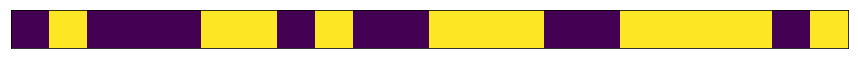

In [43]:
def plot_world(world):
    if type(world) == list:
        A = np.array([world])
    else:
        A = world
    plt.figure(figsize=(15,12)) # (30,30) = Taille de la figure
    plt.imshow(A,cmap='viridis')
    plt.tick_params(top=False, bottom=False, right=False, left=False, labelleft=False, labelbottom=False)
    plt.show()
plot_world(cells)    

**Question 10** : Implémenter les métriques suivantes (une métrique = une fonction) :
- ```happiness_rate``` le ratio d’individus satisfaits,
- ```mean_size_communities``` la taille (moyenne) des regroupements homogènes observés,
- ```nb_communities``` le nombre de regroupements homogènes,
- ```mean_same_type``` la moyenne sur tous les individus du ratio de voisins du même type qu’eux,
- ```nb_iter_to_stability``` le nombre de tours nécessaires pour arriver à un état stable.

In [44]:
def happiness_rate(cells,neigh,threshold):
    '''list[int]*int*Number -> Number'''
    s = 0
    for i in range(len(cells)) :
        if is_happy(cells,i,neigh,threshold) :
            s += 1
    return s/len(cells)
        
def mean_size_communities(cells):
    '''list[int] -> Number'''
    l = [1]
    a = 0
    for i in range(1,len(cells)):
        if cells[i] != cells[i-1] :
            l += [1]
            a += 1
        else :
            l[a] += 1
    s = 0
    for i in l :
        s += i
    return s/len(l)
            
        
def nb_communities(cells):
    '''list[int] -> int'''
    s = 0
    for i in range(1,len(cells)):
        if cells[i] != cells[i-1] :
            s += 1
    return s

def mean_same_type(cells,neigh) :
    '''list[int]*int -> Number'''
    s = 0
    for i in range(len(cells)) :
        s += satisfaction_ratio(cells,i,neigh)
    return s/len(cells)
    
def nb_iter_to_stability(cells,neigh,threshold,max_iter) :
    '''list[int]*int*Number*int'''
    a,b = linear_schelling(cells,neigh,threshold,max_iter)
    return max_iter - b

print(happiness_rate(cells,neigh,threshold))
print(mean_size_communities(cells))
print(nb_communities(cells))
print(mean_same_type(cells,neigh))
print(nb_iter_to_stability(cells,neigh,threshold,max_iter))

0.5909090909090909
1.8333333333333333
11
0.44361471861471863
2


**Question 11 :** Faire varier les paramètres du modèle et observer l'évolution des différentes métriques. Tracer les courbes correspondantes, si elles sont judicieuses, en utilisant matplotlib ; puis décrire les phénomènes observés (pas plus de 3 courbes, un paragraphe par phénomène observé).

*Indices :* Tracer l'évolution du taux de satisfaction au fil des tours. Faire évoluer le seuil de satisfaction par pas de 0.1 de 0 à 1. Etudier la taille des regroupements homogènes en fonction de ce seuil. Nombre de tours nécessaires pour arriver à un état stable en fonction de la taille du monde. 

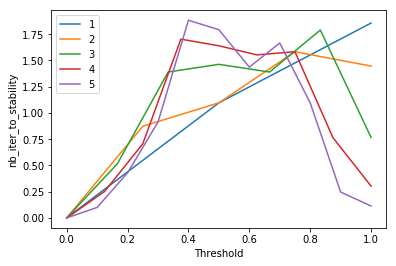

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt


def graph(nbmoy,size,types,max_iter,n1,n2,n3,n4,n5) :
    '''int*list[int]*int*int*int*int -> NoneType'''
    x1 = []
    x2 = []
    x3 = []
    x4 = []
    x5 = []
    y1 = []
    y2 = []
    y3 = []
    y4 = []
    y5 = []
    for i in range(n1*2+1) :
        x1 += [i/(n1*2)]
        y1 += [0]
    for i in range(n2*2+1) :
        x2 += [i/(n2*2)]
        y2 += [0]
    for i in range(n3*2+1) :
        x3 += [i/(n3*2)]
        y3 += [0]
    for i in range(n4*2+1) :
        x4 += [i/(n4*2)]
        y4 += [0]
    for i in range(n5*2+1) :
        x5 += [i/(n5*2)]
        y5 += [0]
    
    
    for i in range(nbmoy) :
    
        cells = generate_linear_world(size,types)

        for i in range(len(x1)) :
            y1[i] += nb_iter_to_stability(cells,n1,x1[i],max_iter)/nbmoy
        for i in range(len(x2)) :
            y2[i] += nb_iter_to_stability(cells,n2,x2[i],max_iter)/nbmoy
        for i in range(len(x3)) :
            y3[i] += nb_iter_to_stability(cells,n3,x3[i],max_iter)/nbmoy
        for i in range(len(x4)) :
            y4[i] += nb_iter_to_stability(cells,n4,x4[i],max_iter)/nbmoy
        for i in range(len(x5)) :
            y5[i] += nb_iter_to_stability(cells,n5,x5[i],max_iter)/nbmoy
    
    plt.plot(x1,y1)
    plt.plot(x2,y2)
    plt.plot(x3,y3)
    plt.plot(x4,y4)
    plt.plot(x5,y5)
    plt.xlabel("Threshold")
    plt.ylabel("nb_iter_to_stability")
    plt.legend([n1,n2,n3,n4,n5])
    plt.show()
    return None

    
graph(300,20,[0,1],10,1,2,3,4,5)

# 2ème partie : Modèle spatial

Dans cette partie le monde que nous allons considérer n'est plus constitué d'une dimension mais de deux dimensions. Si l'on pouvait assimiler le modèle "linéaire" à l'application du modèle de Schelling dans une rue, l'extension à une deuxième dimension permet de modéliser le modèle de Schelling à l'échelle d'une ville (pensons à une carte divisées en emplacements carrés de même taille, chaque carré représentant un immeuble ou un pâté de maisons).

Un emplacement est déterminé par ses coordonnées $(X,Y)$. Par exemple, l'emplacement $(0,0)$ est situé en tout en haut à gauche et l'emplacement $(n,m)$ tout en bas à droite.

L’extension du modèle linéaire au modèle spatial n’est pas triviale. En effet, si toutes les localisations sont occupées, il n’est pas si évident de définir les règles de déplacements (où se déplacent les individus « chassés » de leur localisation ?).

Il est alors plus aisé d’introduire des localisations non occupées. Dans ce cas, les individus non satisfait se déplacent au hasard vers une localisation inoccupée. Contrairement au modèle linéaire, la nouvelle localisation ne satisfait pas forcément le seuil de préférence et n'est pas forcément la plus proche (ces alternatives pourront être implantées en question 5).

# Etude du modèle spatial

In [46]:
# Paramètres du modèle Schelling (à modifier, ne pas oublier de réexécuter la cellule)
neigh2 = 1       # Taille du voisinnage
threshold = 0.5 # Seuil de satisfaction
max_iter = 5    # Nombre de tours
n,m = 7,7       # Taille du monde (n)

**Question 1** : Implanter la fonction ```generate_spatial_world``` permettant de générer des mondes spatiaux aléatoirement (de même : s'interroger sur les paramètres nécessaires). Utiliser ```numpy.array```.  
*Indice* : Pour un emplacement innocupé, nous pouvons créer un nouveau type.

In [47]:
import numpy as np

def generate_spacial_world(n,m,types):
    '''int -> list[list[Number]]'''
    a = np.array([[0 for i in range(m)] for i in range(n)])
    for i in range(n) :
        for j in range(m) :
            a[i,j] = np.random.choice(types)
    return a

print(generate_spacial_world(5,5,[0,1,2]))

[[2 0 2 0 0]
 [1 2 1 0 1]
 [2 0 0 0 0]
 [2 1 0 2 0]
 [0 2 0 0 1]]


**Question 2 :** Implémenter la fonction ```spatial_schelling```, permettant d'appliquer le modèle de schelling sur un monde spatial.  
**Utiliser la [distance de Tchebychev](https://fr.wikipedia.org/wiki/Distance_de_Tchebychev)** dès qu'il est question de comparer des distances entre individus : pour les voisins nous pouvons considérer tous les emplacements dont la distance est inférieure ou égale à ```neigh```.

In [48]:
import copy

world = np.array(generate_spacial_world(5,5,[0,1,2]))

def spatial_neighborhood(world,x,y,neigh):
    '''list[list[float]]*int*int*int -> list[int]'''
    a = []
    for i in range(max(0,x-neigh),min(len(world),x+neigh+1)) :
        b = []
        for j in range(max(0,x-neigh),min(len(world),x+neigh+1)):
            if i == x and j == y :
                b += [0.]
            else :
                b += [world[i,j]]
        a.append(b)
    return np.array(a)

def spatial_satisfaction_ratio(world,x,y,neigh) :
    '''list[list[float]]*int*int*int -> Number'''
    s = 0
    n= np.array(spatial_neighborhood(world,x,y,neigh))
    for i in range(len(n)):
        for j in range(len(n[0])) :
            if n[i,j] == world[x,y] :
                s += 1
    return s / ((2*neigh + 1)**2 - 1)

def spatial_is_happy(world,x,y,neigh,threshold) :
    '''list[list[float]]*int*int*Number -> Bool'''
    return spatial_satisfaction_ratio(world,x,y,neigh) >= threshold

def print_satisfaction(world,neigh,threshold):
    '''list*list*[float]*int*Number -> str'''
    result = "|"
    for i in range(len(world)) :
        for j in range(len(world[0])) :
            if spatial_is_happy(world,i,j,neigh,threshold) :
                result += "C|"
            else :
                result += "E|"
            if j == len(world[0])-1 :
                result += "\n|"
    return result

def spatial_relocation(world,x,y,a,b) :
    w = copy.deepcopy(world)
    v1 = world[x,y]
    v2 = world[a,b]
    w[a,b] = v1
    w[x,y] = v2
    return w

print(neigh2)
print(world)
print(spatial_neighborhood(world,4,4,neigh2))
print(np.array([[spatial_satisfaction_ratio(world,i,j,neigh)for j in range(len(world[0]))] for i in range(len(world))]))
print(print_satisfaction(world,neigh2,threshold))
print(world)
print(spatial_relocation(world,0,0,1,1))

1
[[2 1 1 2 2]
 [0 0 2 0 1]
 [1 0 2 0 2]
 [2 1 2 0 1]
 [2 1 1 0 0]]
[[0. 1.]
 [0. 0.]]
[[0.1    0.0875 0.0875 0.1    0.1   ]
 [0.1    0.1    0.1    0.1    0.0875]
 [0.0875 0.1    0.1    0.1    0.1   ]
 [0.1    0.0875 0.1    0.1    0.0875]
 [0.1    0.0875 0.0875 0.1    0.1   ]]
|E|E|E|E|E|
|E|E|E|E|E|
|E|C|E|C|E|
|E|E|E|C|E|
|E|E|E|E|E|
|
[[2 1 1 2 2]
 [0 0 2 0 1]
 [1 0 2 0 2]
 [2 1 2 0 1]
 [2 1 1 0 0]]
[[0 1 1 2 2]
 [0 2 2 0 1]
 [1 0 2 0 2]
 [2 1 2 0 1]
 [2 1 1 0 0]]


**Question 3 :** Adapter les métriques de la question 10 pour le modèle spatial. 

**Question 4 :** Faire varier les paramètres du modèle et observer l'évolution des différentes métriques. Tracer les courbes correspondantes, si elles sont judicieuses, en utilisant matplotlib ; puis décrire les phénomènes observés (pas plus de 3 courbes, un paragraphe par phénomène observé).  

**Question 5 (optionnelle) :** Proposer des alternatives au modèle.  

# 3ème partie : Animation (Interface Graphique avec tkinter)

In [49]:
import tkinter as Tk